# PROJET 7 : Implmémentez un modèle de scoring
*Mathieu GENTHON (septembre 2020)*

## SOMMAIRE<a class="anchor" id="sommaire"></a>
### 1 - [Contexte du projet](#1)<a class="anchor" id="sommaire"></a>
### 2 - [Importation des librairies](#2)<a class="anchor" id="sommaire"></a>
### 3 - [Fonction utile](#3)<a class="anchor" id="sommaire"></a>
### 4 - [Description et nettoyage du Data Set](#4)<a class="anchor" id="sommaire"></a>
### 5 - [Modélisation](#5)<a class="anchor" id="sommaire"></a>
### 6 - [Appel API](#6)<a class="anchor" id="sommaire"></a>

### 1 - [Contexte du projet](#1)<a class="anchor" id="1"></a>

Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.

Michaël, votre manager, vous incite à sélectionner un kernel Kaggle pour vous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Vous analyserez ce kernel et l’adapterez pour vous assurer qu’il répond aux besoins de votre mission.

Spécifications du dashboard :

Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

### 2 - [Importation des librairies](#2)<a class="anchor" id="2"></a>

In [1]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
from pprint import pprint
from contextlib import contextmanager
# File system manangement
import os
# Suppress warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from lightgbm import LGBMClassifier
# SKLEARN
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
# Export
import pickle
# Interprétabilité
import lime
import lime.lime_tabular

pd.set_option('display.max_columns', None)  # On affiche tte les col des df

### 3 - [Fonction utile pour la suite du calcul](#3)<a class="anchor" id="3"></a>

In [2]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [3]:
def label_encoder(df):
    le_count = 0
    le_column = []
    le = LabelEncoder()
    for col in df:
        if df[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                # Train on the training data
                le.fit(df[col])
                # Transform both training and testing data
                df[col] = le.transform(df[col])
                # Keep track of how many columns were label encoded
                le_count += 1
                le_column.append(col)
                      
    print('%d columns were label encoded.' % le_count , le_column)
    return df

### 4 - [Description et nettoyage du Data Set](#4)<a class="anchor" id="4"></a>

#### 4.1 - [Application_(Train/Test)](#41)<a class="anchor" id="41"></a>

In [4]:
# Load data
path = 'C:/Users/GENTHON-M/Documents/formation/Projet7OC/data/'
path_out = 'C:/Users/GENTHON-M/Documents/formation/Projet7OC//dashboard/output/'
df = pd.read_csv(path+"application_train.csv")
print('Training data shape: ', df.shape)
df.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [5]:
test_df = pd.read_csv(path+"application_test.csv")
print('Testing data shape: ', test_df.shape)
test_df.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

The test set is considerably smaller and lacks a TARGET column.

In [6]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()      
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)      
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)      
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : 'Perc of Total Values'})     
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        'Perc of Total Values', ascending=False).round(1)    
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")  
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  Perc of Total Values
COMMONAREA_MEDI                   214865                  69.9
COMMONAREA_AVG                    214865                  69.9
COMMONAREA_MODE                   214865                  69.9
NONLIVINGAPARTMENTS_MEDI          213514                  69.4
NONLIVINGAPARTMENTS_MODE          213514                  69.4
NONLIVINGAPARTMENTS_AVG           213514                  69.4
FONDKAPREMONT_MODE                210295                  68.4
LIVINGAPARTMENTS_MODE             210199                  68.4
LIVINGAPARTMENTS_MEDI             210199                  68.4
LIVINGAPARTMENTS_AVG              210199                  68.4
FLOORSMIN_MODE                    208642                  67.8
FLOORSMIN_MEDI                    208642                  67.8
FLOORSMIN_AVG                     208642                  67.8
YEARS_BUILD_MODE                  204488                  66.5
YEARS_BUILD_MEDI                  204488                  66.5
YEARS_BUILD_AVG                   204488                  66.5
OWN_CAR_AGE                       202929                  66.0
LANDAREA_AVG                      182590                  59.4
LANDAREA_MEDI                     182590                  59.4
LANDAREA_MODE                     182590                  59.4

When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

In [8]:
anom = df[df['DAYS_EMPLOYED'] == 365243]
non_anom = df[df['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


In [9]:
# list of work for each customer
df_job = df.append(test_df).reset_index() 
df_job = df_job[['SK_ID_CURR','NAME_INCOME_TYPE', 'OCCUPATION_TYPE']]
df_job.OCCUPATION_TYPE = df_job.OCCUPATION_TYPE.fillna(df_job.NAME_INCOME_TYPE)
df_job.to_csv(path_out+"df_job.csv",index=False, sep=',', encoding='utf-8')
df_job

SK_ID_CURR      NAME_INCOME_TYPE       OCCUPATION_TYPE
0           100002               Working              Laborers
1           100003         State servant            Core staff
2           100004               Working              Laborers
3           100006               Working              Laborers
4           100007               Working            Core staff
...            ...                   ...                   ...
356250      456221               Working               Working
356251      456222  Commercial associate           Sales staff
356252      456223  Commercial associate  Commercial associate
356253      456224  Commercial associate              Managers
356254      456250               Working            Core staff

[356255 rows x 3 columns]

In [10]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(df, test_df, num_rows = None, nan_as_category = False):
    # merge test and train
    df = df.append(test_df).reset_index()    
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']    
    # Categorical features with Binary encode (0 or 1; two categories)
    df = label_encoder(df)
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df, cat_cols

In [11]:
df, catApp = application_train_test(df, test_df, num_rows=None)
print("df shape:", df.shape)
df.head()

4 columns were label encoded. ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
df shape: (356251, 247)


index  SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      0      100002     1.0                   0            1             0   
1      1      100003     0.0                   0            0             0   
2      2      100004     0.0                   1            1             1   
3      3      100006     0.0                   0            0             0   
4      4      100007     0.0                   0            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                1             0          202500.0    406597.5      24700.5   
1                0             0          270000.0   1293502.5      35698.5   
2                1             0           67500.0    135000.0       6750.0   
3                1             0          135000.0    312682.5      29686.5   
4                1             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         351000.0                    0.018801       -9461         -637.0   
1        1129500.0                    0.003541      -16765        -1188.0   
2         135000.0                    0.010032      -19046         -225.0   
3         297000.0                    0.008019      -19005        -3039.0   
4         513000.0                    0.028663      -19932        -3038.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0            -3648.0            -2120          NaN           1   
1            -1186.0             -291          NaN           1   
2            -4260.0            -2531         26.0           1   
3            -9833.0            -2437          NaN           1   
4            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                     2                            2   
1              2.0                     1                            1   
2              1.0                     2                            2   
3              2.0                     2                            2   
4              1.0                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0

On remarque ci-après que l'ancienneté moyenne dans le travail est moins importante dans le groupe des clients ayant fait défaut:

1814.918800091596 2438.111433881319


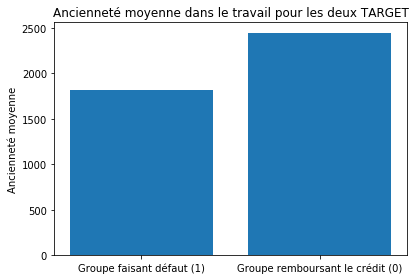

In [12]:
df_default = df[df['TARGET'] == 1]
df_nodefault = df[df['TARGET'] == 0]
Mean_A_D = df_default['DAYS_EMPLOYED'].mean()*-1
Mean_A_N = df_nodefault['DAYS_EMPLOYED'].mean()*-1
print(Mean_A_D, Mean_A_N)
plt.figure(figsize=(6, 4))
plt.bar(x=['Groupe faisant défaut (1)', 'Groupe remboursant le crédit (0)'], height=[Mean_A_D,Mean_A_N])
plt.ylabel('Ancienneté moyenne')
plt.title('Ancienneté moyenne dans le travail pour les deux TARGET',fontsize=12)
plt.tight_layout()
plt.savefig('anc_def.png')

Nous avons affaire à un problème de classification avec un déséquilibre des classes:

0.0    282682
1.0     24825
Name: TARGET, dtype: int64


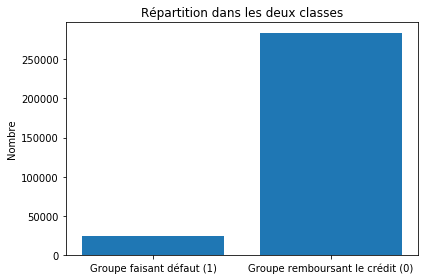

In [13]:
print(df['TARGET'].value_counts())
#df['TARGET'].astype(int).plot.hist()
Size_D = len(df_default.axes[0])
Size_ND = len(df_nodefault.axes[0])
plt.figure(figsize=(6, 4))
plt.bar(x=['Groupe faisant défaut (1)', 'Groupe remboursant le crédit (0)'], height=[Size_D,Size_ND])
plt.ylabel('Nombre')
plt.title('Répartition dans les deux classes',fontsize=12)
plt.tight_layout()
plt.savefig('repar_def.png')

#### 4.2 - [Bureau and Balance](#42)<a class="anchor" id="42"></a>

In [14]:
bureau = pd.read_csv(path+"bureau.csv")
print('Bureau data shape: ', bureau.shape)
bureau.head()

Bureau data shape:  (1716428, 17)


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [15]:
bb = pd.read_csv(path+"bureau_balance.csv")
print('Training data shape: ', bb.shape)
bb.head()

Training data shape:  (27299925, 3)


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [16]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(bureau, bb, num_rows = None, nan_as_category = True):
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category) 
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    print(bb_aggregations)
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [17]:
bureau = bureau_and_balance(bureau, bb, num_rows=None)
print("Bureau df shape:", bureau.shape)
bureau.head()

{'MONTHS_BALANCE': ['min', 'max', 'size'], 'STATUS_0': ['mean'], 'STATUS_1': ['mean'], 'STATUS_2': ['mean'], 'STATUS_3': ['mean'], 'STATUS_4': ['mean'], 'STATUS_5': ['mean'], 'STATUS_C': ['mean'], 'STATUS_X': ['mean'], 'STATUS_nan': ['mean']}
Bureau df shape: (305811, 116)


BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  BURO_DAYS_CREDIT_MEAN  \
SK_ID_CURR                                                                      
100001                     -1572                   -49            -735.000000   
100002                     -1437                  -103            -874.000000   
100003                     -2586                  -606           -1400.750000   
100004                     -1326                  -408            -867.000000   
100005                      -373                   -62            -190.666667   

            BURO_DAYS_CREDIT_VAR  BURO_DAYS_CREDIT_ENDDATE_MIN  \
SK_ID_CURR                                                       
100001             240043.666667                       -1329.0   
100002             186150.000000                       -1072.0   
100003             827783.583333                       -2434.0   
100004             421362.000000                        -595.0   
100005              26340.333333                        -128.0   

            BURO_DAYS_CREDIT_ENDDATE_MAX  BURO_DAYS_CREDIT_ENDDATE_MEAN  \
SK_ID_CURR                                                                
100001                            1778.0                      82.428571   
100002                             780.0                    -349.000000   
100003                            1216.0                    -544.500000   
100004                            -382.0                    -488.500000   
100005                            1324.0                     439.333333   

            BURO_DAYS_CREDIT_UPDATE_MEAN  BURO_CREDIT_DAY_OVERDUE_MAX  \
SK_ID_CURR                                                              
100001                        -93.142857                            0   
100002                       -499.875000                            0   
100003                       -816.000000                            0   
100004                       -532.000000                            0   
100005                        -54.333333                            0   

            BURO_CREDIT_DAY_OVERDUE_MEAN  BURO_AMT_CREDIT_MAX_OVERDUE_MEAN  \
SK_ID_CURR                                                                   
100001                               0.0                               NaN   
100002                               0.0                          1681.029   
100003                               0.0                             0.000   
100004                               0.0                             0.000   
100005                               0.0                             0.000   

            BURO_AMT_CREDIT_SUM_MAX  BURO_AMT_CREDIT_SUM_MEAN  \
SK_ID_CURR                                                      
100001                     378000.0             207623.571429   
100002                     450000.0             108131.945625   
100003                     810000.0             254350.125000   
100004                      94537.8              94518.900000   
100005                     568800.0             219042.000000   

            BURO_AMT_CREDIT_SUM_SUM  BURO_AMT_CREDIT_SUM_DEBT_MAX  \
SK_ID_CURR                                                          
100001                  1453365.000                      373239.0   
100002                   865055.565                      245781.0   
100003                  1017400.500                           0.0   
100004                   189037.800                           0.0   
100005                   657126.000                      543087.0   

            BURO_AMT_CREDIT_SUM_DEBT_MEAN  BURO_AMT_CREDIT_SUM_DEBT_SUM  \
SK_ID_CURR                                                                
100001                       85240.928571                      596686.5   
100002                       49156.200000                      245781.0   
100003                           0.000000                           0.0   
100004                           0.000000                           0.0   
100005

#### 4.3 - [Previous application](#43)<a class="anchor" id="43"></a>

In [18]:
prev = pd.read_csv(path+"previous_application.csv")
print('Training data shape: ', prev.shape)
prev.head()

Training data shape:  (1670214, 37)


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [19]:
# Preprocess previous_applications.csv
def previous_applications(prev, num_rows = None, nan_as_category = True):
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [20]:
prev = previous_applications(prev, num_rows=None)
prev.head()

PREV_AMT_ANNUITY_MIN  PREV_AMT_ANNUITY_MAX  PREV_AMT_ANNUITY_MEAN  \
SK_ID_CURR                                                                      
100001                  3951.000              3951.000               3951.000   
100002                  9251.775              9251.775               9251.775   
100003                  6737.310             98356.995              56553.990   
100004                  5357.250              5357.250               5357.250   
100005                  4813.200              4813.200               4813.200   

            PREV_AMT_APPLICATION_MIN  PREV_AMT_APPLICATION_MAX  \
SK_ID_CURR                                                       
100001                       24835.5                   24835.5   
100002                      179055.0                  179055.0   
100003                       68809.5                  900000.0   
100004                       24282.0                   24282.0   
100005                           0.0                   44617.5   

            PREV_AMT_APPLICATION_MEAN  PREV_AMT_CREDIT_MIN  \
SK_ID_CURR                                                   
100001                       24835.50              23787.0   
100002                      179055.00             179055.0   
100003                      435436.50              68053.5   
100004                       24282.00              20106.0   
100005                       22308.75                  0.0   

            PREV_AMT_CREDIT_MAX  PREV_AMT_CREDIT_MEAN  \
SK_ID_CURR                                              
100001                  23787.0              23787.00   
100002                 179055.0             179055.00   
100003                1035882.0             484191.00   
100004                  20106.0              20106.00   
100005                  40153.5              20076.75   

            PREV_APP_CREDIT_PERC_MIN  PREV_APP_CREDIT_PERC_MAX  \
SK_ID_CURR                                                       
100001                      1.044079                  1.044079   
100002                      1.000000                  1.000000   
100003                      0.868825                  1.011109   
100004                      1.207699                  1.207699   
100005                      1.111173                  1.111173   

            PREV_APP_CREDIT_PERC_MEAN  PREV_APP_CREDIT_PERC_VAR  \
SK_ID_CURR                                                        
100001                       1.044079                       NaN   
100002                       1.000000                       NaN   
100003                       0.949329                  0.005324   
100004                       1.207699                       NaN   
100005                       1.111173                       NaN   

            PREV_AMT_DOWN_PAYMENT_MIN  PREV_AMT_DOWN_PAYMENT_MAX  \
SK_ID_CURR                                                         
100001                         2520.0                     2520.0   
100002                            0.0                        0.0   
100003                            0.0                     6885.0   
100004                         4860.0                     4860.0   
100005                         4464.0                     4464.0   

            PREV_AMT_DOWN_PAYMENT_MEAN  PREV_AMT_GOODS_PRICE_MIN  \
SK_ID_CURR                                                         
100001                          2520.0                   24835.5   
100002                             0.0                  179055.0   
100003                          3442.5                   68809.5   
100004                          4860.0                   24282.0   
100005                          4464.0                   44617.5   

            PREV_AMT_GOODS_PRICE_MAX  PREV_AMT_GOODS_PRICE_MEAN  \
SK_ID_CURR                                                        
100001                       24835.5                    24835.5   
100002                      179055.0                   179

#### 4.4 - [POS Cash balance](#44)<a class="anchor" id="44"></a>

In [21]:
pos = pd.read_csv(path+"POS_CASH_balance.csv")
print('Training data shape: ', pos.shape)
pos.head()

Training data shape:  (10001358, 8)


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [22]:
# Preprocess POS_CASH_balance.csv
def pos_cash(pos,num_rows = None, nan_as_category = True):
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [23]:
pos = pos_cash(pos, num_rows=None)
pos.head()

POS_MONTHS_BALANCE_MAX  POS_MONTHS_BALANCE_MEAN  \
SK_ID_CURR                                                    
100001                         -53               -72.555556   
100002                          -1               -10.000000   
100003                         -18               -43.785714   
100004                         -24               -25.500000   
100005                         -15               -20.000000   

            POS_MONTHS_BALANCE_SIZE  POS_SK_DPD_MAX  POS_SK_DPD_MEAN  \
SK_ID_CURR                                                             
100001                            9               7         0.777778   
100002                           19               0         0.000000   
100003                           28               0         0.000000   
100004                            4               0         0.000000   
100005                           11               0         0.000000   

            POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  \
SK_ID_CURR                                            
100001                       7             0.777778   
100002                       0             0.000000   
100003                       0             0.000000   
100004                       0             0.000000   
100005                       0             0.000000   

            POS_NAME_CONTRACT_STATUS_Active_MEAN  \
SK_ID_CURR                                         
100001                                  0.777778   
100002                                  1.000000   
100003                                  0.928571   
100004                                  0.750000   
100005                                  0.818182   

            POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
SK_ID_CURR                                                 
100001                                               0.0   
100002                                               0.0   
100003                                               0.0   
100004                                               0.0   
100005                                               0.0   

            POS_NAME_CONTRACT_STATUS_Approved_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   
100002                                         0.0   
100003                                         0.0   
100004                                         0.0   
100005                                         0.0   

            POS_NAME_CONTRACT_STATUS_Canceled_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   
100002                                         0.0   
100003                                         0.0   
100004                                         0.0   
100005                                         0.0   

            POS_NAME_CONTRACT_STATUS_Completed_MEAN  \
SK_ID_CURR                                            
100001                                     0.222222   
100002                                     0.000000   
100003                                     0.071429   
100004                                     0.250000   
100005                                     0.090909   

            POS_NAME_CONTRACT_STATUS_Demand_MEAN  \
SK_ID_CURR                                         
100001                                       0.0   
100002                                       0.0   
100003                                       0.0   
100004                                       0.0   
100005                                       0.0   

            POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN  \
SK_ID_CURR                                                        
100001                                                    0.0     
100002                                                    0.0     
100003                                                    0.0     
100004                                           

#### 4.5 - [Instalment payments](#45)<a class="anchor" id="45"></a>

In [24]:
ins = pd.read_csv(path+"installments_payments.csv")
print('Training data shape: ', ins.shape)
ins.head()

Training data shape:  (13605401, 8)


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [25]:
# Preprocess installments_payments.csv
def installments_payments(ins, num_rows = None, nan_as_category = True):
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [26]:
ins = installments_payments(ins, num_rows=None)
ins.head()

INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE  INSTAL_DPD_MAX  \
SK_ID_CURR                                                          
100001                                          2            11.0   
100002                                          2             0.0   
100003                                          2             0.0   
100004                                          2             0.0   
100005                                          2             1.0   

            INSTAL_DPD_MEAN  INSTAL_DPD_SUM  INSTAL_DBD_MAX  INSTAL_DBD_MEAN  \
SK_ID_CURR                                                                     
100001             1.571429            11.0            36.0         8.857143   
100002             0.000000             0.0            31.0        20.421053   
100003             0.000000             0.0            14.0         7.160000   
100004             0.000000             0.0            11.0         7.666667   
100005             0.111111             1.0            37.0        23.666667   

            INSTAL_DBD_SUM  INSTAL_PAYMENT_PERC_MAX  INSTAL_PAYMENT_PERC_MEAN  \
SK_ID_CURR                                                                      
100001                62.0                      1.0                       1.0   
100002               388.0                      1.0                       1.0   
100003               179.0                      1.0                       1.0   
100004                23.0                      1.0                       1.0   
100005               213.0                      1.0                       1.0   

            INSTAL_PAYMENT_PERC_SUM  INSTAL_PAYMENT_PERC_VAR  \
SK_ID_CURR                                                     
100001                          7.0                      0.0   
100002                         19.0                      0.0   
100003                         25.0                      0.0   
100004                          3.0                      0.0   
100005                          9.0                      0.0   

            INSTAL_PAYMENT_DIFF_MAX  INSTAL_PAYMENT_DIFF_MEAN  \
SK_ID_CURR                                                      
100001                          0.0                       0.0   
100002                          0.0                       0.0   
100003                          0.0                       0.0   
100004                          0.0                       0.0   
100005                          0.0                       0.0   

            INSTAL_PAYMENT_DIFF_SUM  INSTAL_PAYMENT_DIFF_VAR  \
SK_ID_CURR                                                     
100001                          0.0                      0.0   
100002                          0.0                      0.0   
100003                          0.0                      0.0   
100004                          0.0                      0.0   
100005                          0.0                      0.0   

            INSTAL_AMT_INSTALMENT_MAX  INSTAL_AMT_INSTALMENT_MEAN  \
SK_ID_CURR                                                          
100001                      17397.900                 5885.132143   
100002                      53093.745                11559.247105   
100003                     560835.360                64754.586000   
100004                      10573.965                 7096.155000   
100005                      17656.245                 6240.205000   

            INSTAL_AMT_INSTALMENT_SUM  INSTAL_AMT_PAYMENT_MIN  \
SK_ID_CURR                                                      
100001                      41195.925                3951.000   
100002                     219625.695                9251.775   
100003                    1618864.650                6662.970   
100004                      21288.465                5357.250   
100005                      56161.845                4813.200   

            INSTAL_AMT_PAYMENT_MAX  INSTAL_AMT_PAYMENT_MEAN  \
SK_ID_CURR                                

#### 4.6 - [Credit card balance](#46)<a class="anchor" id="46"></a>

In [27]:
cc = pd.read_csv(path+"credit_card_balance.csv")
print('Training data shape: ', cc.shape)
cc.head()

Training data shape:  (3840312, 23)


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [28]:
# Preprocess credit_card_balance.csv
def credit_card_balance(cc, num_rows = None, nan_as_category = True):
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [29]:
cc = credit_card_balance(cc, num_rows=None)
cc.head()

CC_MONTHS_BALANCE_MIN  CC_MONTHS_BALANCE_MAX  \
SK_ID_CURR                                                 
100006                         -6                     -1   
100011                        -75                     -2   
100013                        -96                     -1   
100021                        -18                     -2   
100023                        -11                     -4   

            CC_MONTHS_BALANCE_MEAN  CC_MONTHS_BALANCE_SUM  \
SK_ID_CURR                                                  
100006                        -3.5                    -21   
100011                       -38.5                  -2849   
100013                       -48.5                  -4656   
100021                       -10.0                   -170   
100023                        -7.5                    -60   

            CC_MONTHS_BALANCE_VAR  CC_AMT_BALANCE_MIN  CC_AMT_BALANCE_MAX  \
SK_ID_CURR                                                                  
100006                        3.5                 0.0                0.00   
100011                      462.5                 0.0           189000.00   
100013                      776.0                 0.0           161420.22   
100021                       25.5                 0.0                0.00   
100023                        6.0                 0.0                0.00   

            CC_AMT_BALANCE_MEAN  CC_AMT_BALANCE_SUM  CC_AMT_BALANCE_VAR  \
SK_ID_CURR                                                                
100006                 0.000000               0.000        0.000000e+00   
100011             54482.111149         4031676.225        4.641321e+09   
100013             18159.919219         1743352.245        1.869473e+09   
100021                 0.000000               0.000        0.000000e+00   
100023                 0.000000               0.000        0.000000e+00   

            CC_AMT_CREDIT_LIMIT_ACTUAL_MIN  CC_AMT_CREDIT_LIMIT_ACTUAL_MAX  \
SK_ID_CURR                                                                   
100006                              270000                          270000   
100011                               90000                          180000   
100013                               45000                          157500   
100021                              675000                          675000   
100023                               45000                          225000   

            CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN  CC_AMT_CREDIT_LIMIT_ACTUAL_SUM  \
SK_ID_CURR                                                                    
100006                        270000.000000                         1620000   
100011                        164189.189189                        12150000   
100013                        131718.750000                        12645000   
100021                        675000.000000                        11475000   
100023                        135000.000000                         1080000   

            CC_AMT_CREDIT_LIMIT_ACTUAL_VAR  CC_AMT_DRAWINGS_ATM_CURRENT_MIN  \
SK_ID_CURR                                                                    
100006                        0.000000e+00                              NaN   
100011                        1.189060e+09                              0.0   
100013                        2.259252e+09                              0.0   
100021                        0.000000e+00                              NaN   
100023                        9.257143e+09                              NaN   

            CC_AMT_DRAWINGS_ATM_CURRENT_MAX  CC_AMT_DRAWINGS_ATM_CURRENT_MEAN  \
SK_ID_CURR                                                                      
100006                                  NaN                               NaN   
100011                             180000.0                       2432.432432   
100013                             157500.0                       6350.000000   
100021                               

#### 4.7 - [Jointure des data frames](#47)<a class="anchor" id="47"></a>

In [30]:
print("df shape:", df.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau
print("Ajout de bureau:", df.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev
print("Ajout de previous:", df.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos
print("Ajout de pos cash:", df.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins
print("Ajout de Installment", df.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
print("Ajout de Credit Card", df.shape)
del cc
gc.collect()

df shape: (356251, 247)
Ajout de bureau: (356251, 363)
Ajout de previous: (356251, 612)
Ajout de pos cash: (356251, 630)
Ajout de Installment (356251, 656)
Ajout de Credit Card (356251, 797)


0

### 5 - [Modélisation](#5)<a class="anchor" id="5"></a>

#### 5.1 - [Métrique ROC Area](#51)<a class="anchor" id="51"></a>

In [31]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [32]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    
    # LightGBMError: Do not support special JSON characters
    import re
    train_df = train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization (https://github.com/fmfn/BayesianOptimization)
        clf = LGBMClassifier(
            boosting_type='goss',
            n_estimators=6000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 20)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        # Prédire sur les données test
        #sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    #if not debug:
        #test_df['TARGET'] = sub_preds
        #test_df[['SK_ID_CURR', 'TARGET']].to_csv(path+submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

Starting LightGBM. Train shape: (307507, 797), test shape: (48744, 797)
Training until validation scores don't improve for 20 rounds
[200]	training's auc: 0.801265	training's binary_logloss: 0.233832	valid_1's auc: 0.772019	valid_1's binary_logloss: 0.242656
[400]	training's auc: 0.826201	training's binary_logloss: 0.223291	valid_1's auc: 0.781646	valid_1's binary_logloss: 0.238884
[600]	training's auc: 0.843448	training's binary_logloss: 0.216251	valid_1's auc: 0.785203	valid_1's binary_logloss: 0.237608
[800]	training's auc: 0.858122	training's binary_logloss: 0.210134	valid_1's auc: 0.786965	valid_1's binary_logloss: 0.237012
Early stopping, best iteration is:
[964]	training's auc: 0.868957	training's binary_logloss: 0.205512	valid_1's auc: 0.787843	valid_1's binary_logloss: 0.236744
Fold  1 AUC : 0.787843
Training until validation scores don't improve for 20 rounds
[200]	training's auc: 0.800826	training's binary_logloss: 0.234021	valid_1's auc: 0.774052	valid_1's binary_logloss: 0

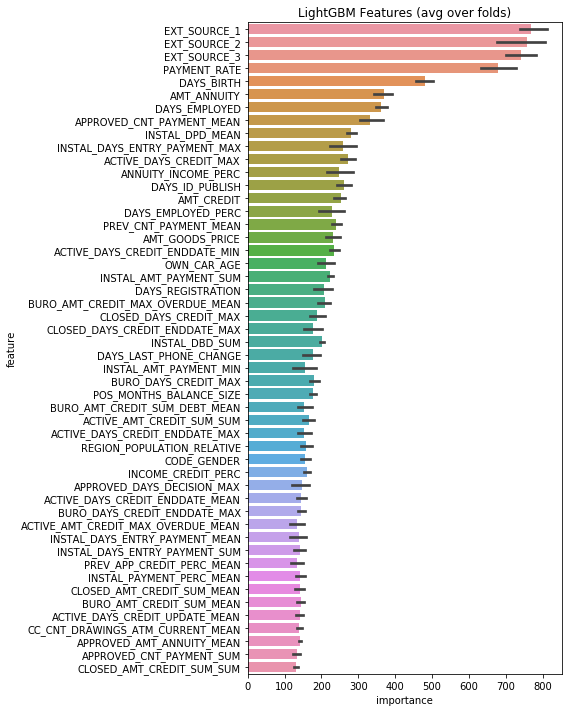

In [33]:
t0 = time.time()
feat_imp = kfold_lightgbm(df, num_folds=4, stratified = True, debug=False)
print("{} - done in {:.0f}s".format('Modèle entrainé :', time.time() - t0))

#### 5.2 - [Réduction taille dataframe pour optimiser le coût de calcul](#52)<a class="anchor" id="52"></a>

In [34]:
cols = feat_imp[["feature", "importance"]].groupby("feature").mean().\
                                            sort_values(by="importance",
                                            ascending=False)[:50].index

Most_important_features = cols.tolist()

In [35]:
# Missing values statistics
missing_values_final = missing_values_table(df)
missing_values_final.head(360)

Your selected dataframe has 797 columns.
There are 617 columns that have missing values.


Missing Values  Perc of Total Values
REFUSED_RATE_DOWN_PAYMENT_MAX                    303648                  85.2
REFUSED_RATE_DOWN_PAYMENT_MIN                    303648                  85.2
REFUSED_RATE_DOWN_PAYMENT_MEAN                   303648                  85.2
REFUSED_AMT_DOWN_PAYMENT_MIN                     303648                  85.2
REFUSED_AMT_DOWN_PAYMENT_MAX                     303648                  85.2
...                                                 ...                   ...
PREV_AMT_DOWN_PAYMENT_MAX                         37502                  10.5
APPROVED_AMT_GOODS_PRICE_MIN                      19634                   5.5
APPROVED_AMT_GOODS_PRICE_MAX                      19634                   5.5
APPROVED_AMT_GOODS_PRICE_MEAN                     19634                   5.5
POS_NAME_CONTRACT_STATUS_Completed_MEAN           19003                   5.3

[360 rows x 2 columns]

In [36]:
# Feature not filled
Sort_feature_df = missing_values_final[missing_values_final['Perc of Total Values']>0]
Feature_not_filled = Sort_feature_df.index.tolist()
Feature_not_filled

['REFUSED_RATE_DOWN_PAYMENT_MAX',
 'REFUSED_RATE_DOWN_PAYMENT_MIN',
 'REFUSED_RATE_DOWN_PAYMENT_MEAN',
 'REFUSED_AMT_DOWN_PAYMENT_MIN',
 'REFUSED_AMT_DOWN_PAYMENT_MAX',
 'REFUSED_AMT_DOWN_PAYMENT_MEAN',
 'REFUSED_APP_CREDIT_PERC_VAR',
 'CC_AMT_PAYMENT_CURRENT_VAR',
 'CC_CNT_DRAWINGS_POS_CURRENT_VAR',
 'CC_AMT_DRAWINGS_OTHER_CURRENT_VAR',
 'CC_CNT_DRAWINGS_OTHER_CURRENT_VAR',
 'CC_AMT_DRAWINGS_POS_CURRENT_VAR',
 'CC_CNT_DRAWINGS_ATM_CURRENT_VAR',
 'CC_AMT_DRAWINGS_ATM_CURRENT_VAR',
 'CC_AMT_PAYMENT_CURRENT_MEAN',
 'CC_AMT_PAYMENT_CURRENT_MAX',
 'CC_AMT_PAYMENT_CURRENT_MIN',
 'CC_AMT_DRAWINGS_POS_CURRENT_MEAN',
 'CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN',
 'CC_AMT_DRAWINGS_OTHER_CURRENT_MAX',
 'CC_AMT_DRAWINGS_OTHER_CURRENT_MIN',
 'CC_AMT_DRAWINGS_POS_CURRENT_MIN',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MAX',
 'CC_AMT_DRAWINGS_POS_CURRENT_MAX',
 'CC_CNT_DRAWINGS_POS_CURRENT_MAX',
 'CC_CNT_DRAWINGS_POS_CURRENT_MEAN',
 'CC_AMT_DRAWINGS_ATM_CURRENT_MAX',
 'CC_CNT_DRAWINGS_POS_CURRENT_MIN',
 'CC_CNT_DRAWIN

In [37]:
# Important feature not filled
Important_feature_not_filled = list(set(Most_important_features).intersection(Feature_not_filled))
Important_feature_not_filled.append('TARGET')
Important_feature_not_filled

['ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'DAYS_EMPLOYED_PERC',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'INSTAL_PAYMENT_PERC_MEAN',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'EXT_SOURCE_1',
 'BURO_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'APPROVED_AMT_ANNUITY_MEAN',
 'EXT_SOURCE_2',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'INSTAL_AMT_PAYMENT_MIN',
 'CLOSED_DAYS_CREDIT_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'CLOSED_AMT_CREDIT_SUM_MEAN',
 'INSTAL_AMT_PAYMENT_SUM',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'POS_MONTHS_BALANCE_SIZE',
 'BURO_AMT_CREDIT_SUM_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'INSTAL_DBD_SUM',
 'PREV_CNT_PAYMENT_MEAN',
 'EXT_SOURCE_3',
 'APPROVED_CNT_PAYMENT_SUM',
 'ACTIVE_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'OWN_CAR_AGE',
 'DAYS_EMPLOYED',
 'APPROVED_DAYS_DECISION_MAX',
 'AMT_GOODS_PRICE'

In [38]:
# Remove not important feature not filled.
Feature_removed = [x for x in Feature_not_filled if x not in Important_feature_not_filled]
len(Feature_removed)

571

In [39]:
df_max_profit = df.drop(Feature_removed, axis=1)

In [40]:
df_max_profit_train = df_max_profit[df_max_profit['TARGET'].notnull()]
df_max_profit_test = df_max_profit[df_max_profit['TARGET'].isnull()]

# Class count
count_class_0, count_class_1 = df_max_profit_train['TARGET'].value_counts()

# Divide by class
df_class_0 = df_max_profit_train[df_max_profit_train['TARGET'] == 0]
df_class_1 = df_max_profit_train[df_max_profit_train['TARGET'] == 1]

# Divide sample to improve calculation time
df_class_0_under = df_class_0.sample(int(count_class_0/2))
df_class_1_under = df_class_1.sample(int(count_class_1/2))
df_test_under = pd.concat([df_class_0_under, df_class_1_under, df_max_profit_test], axis=0)

df_test_under

index  SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  \
6089      6089      107120     0.0                   0            0   
112946  112946      231003     0.0                   1            0   
175619  175619      303510     0.0                   0            0   
124603  124603      244505     0.0                   0            1   
225396  225396      361073     0.0                   1            0   
...        ...         ...     ...                 ...          ...   
356250   48739      456221     NaN                   0            0   
356251   48740      456222     NaN                   0            0   
356252   48741      456223     NaN                   0            0   
356253   48742      456224     NaN                   0            1   
356254   48743      456250     NaN                   0            0   

        FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
6089               1                0             0          135000.0   
112946             0                1             0          360000.0   
175619             0                1             1          157500.0   
124603             1                0             0          202500.0   
225396             0                1             0          112500.0   
...              ...              ...           ...               ...   
356250             0                1             0          121500.0   
356251             0                0             2          157500.0   
356252             1                1             1          202500.0   
356253             0                0             0          225000.0   
356254             1                0             0          135000.0   

        AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
6089      505066.5      27036.0         468000.0                    0.010147   
112946    495000.0      24750.0         495000.0                    0.011657   
175619    675000.0      50598.0         675000.0                    0.005002   
124603   1350000.0      39474.0        1350000.0                    0.035792   
225396    315000.0      15750.0         315000.0                    0.020246   
...            ...          ...              ...                         ...   
356250    412560.0      17473.5         270000.0                    0.002042   
356251    622413.0      31909.5         495000.0                    0.035792   
356252    315000.0      33205.5         315000.0                    0.026392   
356253    450000.0      25128.0         450000.0                    0.018850   
356254    312768.0      24709.5         270000.0                    0.006629   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
6089        -17335        -4971.0            -8737.0             -874   
112946      -22540            NaN            -6983.0            -1925   
175619      -11004        -4222.0            -5350.0             -764   
124603      -16662        -2503.0            -2511.0             -197   
225396      -19290        -1275.0            -2170.0            -1131   
...            ...            ...                ...              ...   
356250      -19970        -5169.0            -9094.0            -3399   
356251      -11186        -1149.0            -3015.0            -3003   
356252      -15922        -3037.0            -2681.0            -1504   
356253      -13968        -2731.0            -1461.0            -1364   
356254      -13962         -633.0            -1072.0            -4220   

        OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
6089           17.0           1               1                0   
112946          NaN           1               0                0   
175619          NaN           1               1                0   
124603          3.0           1               1                0   
225396          NaN           1               1                1   
...             ...         ...  

#### 5.3 - [Métrique personnalisé pour maximiser le profit](#53)<a class="anchor" id="53"></a>

In [42]:
# Build a custom loss function to maximize profit given that it is better not to grant a loan to a good
# customer than granting a loan to bad customers.

def Maximize_profit_evo(y_true, p_pred):
    TP_value, FP_value = 0, 0
    TN_value = 1
    FN_value = -10
    score = 0
    for proba in np.linspace(0.04,0.20,8):
        counter = 0
        perfect = 0
        for i in range(len(y_true)): 
            if y_true[i]==1 and p_pred[i]>proba:
                counter += TP_value
                perfect += TP_value
            if y_true[i]==0 and p_pred[i]>proba:
                counter += FP_value
                perfect += TN_value
            if y_true[i]==0 and p_pred[i]<proba:
                counter += TN_value
                perfect += TN_value
            if y_true[i]==1 and p_pred[i]<proba:
                counter += FN_value
                perfect += TP_value
        if counter/perfect > score:
            score=counter/perfect
            threshold=proba
    print('seuil pour maximiser les profits :{}'.format(threshold))
    return 'counter', score, True 
# return name of metric, the loss itself, and a boolean about whether higher is better

In [43]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm2(df, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    
    # LightGBMError: Do not support special JSON characters
    import re
    train_df = train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
        # Cross validation model
    folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1001)
        
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR',
                                                      'SK_ID_BUREAU','SK_ID_PREV','index']]
    model = LGBMClassifier(
        boosting_type='goss',
        n_estimators=6000,
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        silent=-1,
        verbose=-1 )   
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric=Maximize_profit_evo,
                  verbose=1,
                  early_stopping_rounds=30
                 )
        
        oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
        # Prédire sur les données test
        sub_preds += model.predict_proba(test_df[feats], num_iteration=model.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        
    test_df['TARGET'] = sub_preds
    gc.collect()
    display_importances(feature_importance_df)
    return model, oof_preds, sub_preds, feature_importance_df, test_df

Starting LightGBM. Train shape: (153753, 226), test shape: (48744, 226)
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[1]	training's binary_logloss: 0.279283	training's counter: 0.142666	valid_1's binary_logloss: 0.279377	valid_1's counter: 0.138855
Training until validation scores don't improve for 30 rounds
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[2]	training's binary_logloss: 0.278081	training's counter: 0.284695	valid_1's binary_logloss: 0.278288	valid_1's counter: 0.265017
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[3]	training's binary_logloss: 0.276943	training's counter: 0.334108	valid_1's binary_logloss: 0.277262	valid_1's counter: 0.304092
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[4]	training's binary_logloss: 0.275882

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[35]	training's binary_logloss: 0.257086	training's counter: 0.423594	valid_1's binary_logloss: 0.260619	valid_1's counter: 0.392856
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[36]	training's binary_logloss: 0.256716	training's counter: 0.424316	valid_1's binary_logloss: 0.260339	valid_1's counter: 0.393047
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[37]	training's binary_logloss: 0.256343	training's counter: 0.423594	valid_1's binary_logloss: 0.260053	valid_1's counter: 0.391837
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[38]	training's binary_logloss: 0.255968	training's counter: 0.424708	valid_1's binary_logloss: 0.259762	valid_1's counter: 0.392665
seuil pour maximiser les profits :0.

seuil pour maximiser les profits :0.08571428571428572
[69]	training's binary_logloss: 0.246948	training's counter: 0.450317	valid_1's binary_logloss: 0.253298	valid_1's counter: 0.405676
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[70]	training's binary_logloss: 0.246695	training's counter: 0.449871	valid_1's binary_logloss: 0.253123	valid_1's counter: 0.407352
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[71]	training's binary_logloss: 0.246447	training's counter: 0.451516	valid_1's binary_logloss: 0.252948	valid_1's counter: 0.405654
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[72]	training's binary_logloss: 0.24621	training's counter: 0.451909	valid_1's binary_logloss: 0.252832	valid_1's counter: 0.406376
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.0

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[104]	training's binary_logloss: 0.239876	training's counter: 0.471287	valid_1's binary_logloss: 0.248975	valid_1's counter: 0.418241
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[105]	training's binary_logloss: 0.239731	training's counter: 0.472359	valid_1's binary_logloss: 0.248874	valid_1's counter: 0.418114
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[106]	training's binary_logloss: 0.239553	training's counter: 0.472901	valid_1's binary_logloss: 0.248795	valid_1's counter: 0.419769
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[107]	training's binary_logloss: 0.239392	training's counter: 0.474301	valid_1's binary_logloss: 0.248677	valid_1's counter: 0.419005
seuil pour maximiser les profits

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[138]	training's binary_logloss: 0.235295	training's counter: 0.484691	valid_1's binary_logloss: 0.246687	valid_1's counter: 0.425861
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[139]	training's binary_logloss: 0.23517	training's counter: 0.484712	valid_1's binary_logloss: 0.246632	valid_1's counter: 0.425521
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[140]	training's binary_logloss: 0.235051	training's counter: 0.48692	valid_1's binary_logloss: 0.24657	valid_1's counter: 0.42567
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[141]	training's binary_logloss: 0.234929	training's counter: 0.488162	valid_1's binary_logloss: 0.246532	valid_1's counter: 0.427198
seuil pour maximiser les profits :0.

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[172]	training's binary_logloss: 0.231563	training's counter: 0.497586	valid_1's binary_logloss: 0.245236	valid_1's counter: 0.433799
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[173]	training's binary_logloss: 0.231443	training's counter: 0.498254	valid_1's binary_logloss: 0.245199	valid_1's counter: 0.433417
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[174]	training's binary_logloss: 0.23134	training's counter: 0.499188	valid_1's binary_logloss: 0.245171	valid_1's counter: 0.433077
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[175]	training's binary_logloss: 0.231246	training's counter: 0.498403	valid_1's binary_logloss: 0.245149	valid_1's counter: 0.43416
seuil pour maximiser les profits :

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[206]	training's binary_logloss: 0.228462	training's counter: 0.509334	valid_1's binary_logloss: 0.244315	valid_1's counter: 0.437407
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[207]	training's binary_logloss: 0.228385	training's counter: 0.509854	valid_1's binary_logloss: 0.244292	valid_1's counter: 0.437386
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[208]	training's binary_logloss: 0.228306	training's counter: 0.510204	valid_1's binary_logloss: 0.244278	valid_1's counter: 0.437259
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[209]	training's binary_logloss: 0.228193	training's counter: 0.509981	valid_1's binary_logloss: 0.24424	valid_1's counter: 0.437938
seuil pour maximiser les profits 

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[240]	training's binary_logloss: 0.225847	training's counter: 0.518822	valid_1's binary_logloss: 0.243727	valid_1's counter: 0.442735
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[241]	training's binary_logloss: 0.225778	training's counter: 0.518885	valid_1's binary_logloss: 0.243723	valid_1's counter: 0.442798
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[242]	training's binary_logloss: 0.225698	training's counter: 0.519193	valid_1's binary_logloss: 0.243716	valid_1's counter: 0.443202
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[243]	training's binary_logloss: 0.225629	training's counter: 0.518885	valid_1's binary_logloss: 0.243711	valid_1's counter: 0.443966
seuil pour maximiser les profits

Fold  1 AUC : 0.768132
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[1]	training's binary_logloss: 0.279283	training's counter: 0.156102	valid_1's binary_logloss: 0.279402	valid_1's counter: 0.151505
Training until validation scores don't improve for 30 rounds
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[2]	training's binary_logloss: 0.278098	training's counter: 0.265306	valid_1's binary_logloss: 0.278354	valid_1's counter: 0.244068
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[3]	training's binary_logloss: 0.276977	training's counter: 0.331869	valid_1's binary_logloss: 0.277374	valid_1's counter: 0.29955
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[4]	training's binary_logloss: 0.275919	training's counter: 0.359112	valid_1's binary_log

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[35]	training's binary_logloss: 0.257388	training's counter: 0.421249	valid_1's binary_logloss: 0.260329	valid_1's counter: 0.398565
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[36]	training's binary_logloss: 0.25702	training's counter: 0.423276	valid_1's binary_logloss: 0.260022	valid_1's counter: 0.397759
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[37]	training's binary_logloss: 0.256648	training's counter: 0.424167	valid_1's binary_logloss: 0.25971	valid_1's counter: 0.397079
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[38]	training's binary_logloss: 0.256287	training's counter: 0.423042	valid_1's binary_logloss: 0.259416	valid_1's counter: 0.396973
seuil pour maximiser les profits :0.08

seuil pour maximiser les profits :0.08571428571428572
[69]	training's binary_logloss: 0.247191	training's counter: 0.450158	valid_1's binary_logloss: 0.252628	valid_1's counter: 0.41614
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[70]	training's binary_logloss: 0.246959	training's counter: 0.45038	valid_1's binary_logloss: 0.252474	valid_1's counter: 0.416161
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[71]	training's binary_logloss: 0.246766	training's counter: 0.451283	valid_1's binary_logloss: 0.252321	valid_1's counter: 0.416161
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[72]	training's binary_logloss: 0.24653	training's counter: 0.452492	valid_1's binary_logloss: 0.252184	valid_1's counter: 0.416607
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.085

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[104]	training's binary_logloss: 0.240443	training's counter: 0.47462	valid_1's binary_logloss: 0.248227	valid_1's counter: 0.426264
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[105]	training's binary_logloss: 0.240282	training's counter: 0.47515	valid_1's binary_logloss: 0.248161	valid_1's counter: 0.426773
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[106]	training's binary_logloss: 0.24014	training's counter: 0.474588	valid_1's binary_logloss: 0.248096	valid_1's counter: 0.425967
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[107]	training's binary_logloss: 0.23999	training's counter: 0.475639	valid_1's binary_logloss: 0.247979	valid_1's counter: 0.429426
seuil pour maximiser les profits :0.

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[138]	training's binary_logloss: 0.235693	training's counter: 0.489509	valid_1's binary_logloss: 0.245605	valid_1's counter: 0.439466
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[139]	training's binary_logloss: 0.235578	training's counter: 0.490433	valid_1's binary_logloss: 0.245544	valid_1's counter: 0.439551
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[140]	training's binary_logloss: 0.235463	training's counter: 0.492608	valid_1's binary_logloss: 0.245498	valid_1's counter: 0.439657
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[141]	training's binary_logloss: 0.235354	training's counter: 0.492269	valid_1's binary_logloss: 0.245448	valid_1's counter: 0.441355
seuil pour maximiser les profits

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[172]	training's binary_logloss: 0.232102	training's counter: 0.501767	valid_1's binary_logloss: 0.244043	valid_1's counter: 0.441143
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[173]	training's binary_logloss: 0.232018	training's counter: 0.501926	valid_1's binary_logloss: 0.244004	valid_1's counter: 0.440676
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[174]	training's binary_logloss: 0.231928	training's counter: 0.50199	valid_1's binary_logloss: 0.24398	valid_1's counter: 0.441758
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[175]	training's binary_logloss: 0.231816	training's counter: 0.501979	valid_1's binary_logloss: 0.243942	valid_1's counter: 0.442077
seuil pour maximiser les profits :

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[206]	training's binary_logloss: 0.229183	training's counter: 0.510247	valid_1's binary_logloss: 0.242947	valid_1's counter: 0.44751
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[207]	training's binary_logloss: 0.229097	training's counter: 0.511308	valid_1's binary_logloss: 0.242896	valid_1's counter: 0.446109
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[208]	training's binary_logloss: 0.229032	training's counter: 0.511329	valid_1's binary_logloss: 0.242865	valid_1's counter: 0.447107
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[209]	training's binary_logloss: 0.228972	training's counter: 0.512295	valid_1's binary_logloss: 0.242842	valid_1's counter: 0.446003
seuil pour maximiser les profits 

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[240]	training's binary_logloss: 0.226556	training's counter: 0.523873	valid_1's binary_logloss: 0.242228	valid_1's counter: 0.446767
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[241]	training's binary_logloss: 0.226476	training's counter: 0.523873	valid_1's binary_logloss: 0.242223	valid_1's counter: 0.447998
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[242]	training's binary_logloss: 0.226393	training's counter: 0.523831	valid_1's binary_logloss: 0.242198	valid_1's counter: 0.447829
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[243]	training's binary_logloss: 0.226327	training's counter: 0.523746	valid_1's binary_logloss: 0.24217	valid_1's counter: 0.447086
seuil pour maximiser les profits 

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[18]	training's binary_logloss: 0.26522	training's counter: 0.412945	valid_1's binary_logloss: 0.266915	valid_1's counter: 0.386539
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[19]	training's binary_logloss: 0.264648	training's counter: 0.413624	valid_1's binary_logloss: 0.266414	valid_1's counter: 0.386666
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[20]	training's binary_logloss: 0.264089	training's counter: 0.411884	valid_1's binary_logloss: 0.265926	valid_1's counter: 0.386984
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[21]	training's binary_logloss: 0.263549	training's counter: 0.413412	valid_1's binary_logloss: 0.265463	valid_1's counter: 0.388025
seuil pour maximiser les profits :0.0

seuil pour maximiser les profits :0.08571428571428572
[52]	training's binary_logloss: 0.252079	training's counter: 0.426115	valid_1's binary_logloss: 0.25613	valid_1's counter: 0.401482
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[53]	training's binary_logloss: 0.251777	training's counter: 0.427537	valid_1's binary_logloss: 0.255926	valid_1's counter: 0.400144
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[54]	training's binary_logloss: 0.251512	training's counter: 0.428004	valid_1's binary_logloss: 0.255713	valid_1's counter: 0.402097
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[55]	training's binary_logloss: 0.251213	training's counter: 0.42983	valid_1's binary_logloss: 0.255475	valid_1's counter: 0.403625
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[87]	training's binary_logloss: 0.243977	training's counter: 0.455013	valid_1's binary_logloss: 0.250079	valid_1's counter: 0.422261
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[88]	training's binary_logloss: 0.243794	training's counter: 0.456234	valid_1's binary_logloss: 0.249941	valid_1's counter: 0.422389
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[89]	training's binary_logloss: 0.243551	training's counter: 0.457093	valid_1's binary_logloss: 0.249759	valid_1's counter: 0.423301
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[90]	training's binary_logloss: 0.243384	training's counter: 0.458112	valid_1's binary_logloss: 0.249673	valid_1's counter: 0.422813
seuil pour maximiser les profits :0.

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[121]	training's binary_logloss: 0.238408	training's counter: 0.477745	valid_1's binary_logloss: 0.246644	valid_1's counter: 0.430051
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[122]	training's binary_logloss: 0.238284	training's counter: 0.477936	valid_1's binary_logloss: 0.24658	valid_1's counter: 0.429372
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[123]	training's binary_logloss: 0.238163	training's counter: 0.478467	valid_1's binary_logloss: 0.24653	valid_1's counter: 0.429605
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[124]	training's binary_logloss: 0.238031	training's counter: 0.479295	valid_1's binary_logloss: 0.246466	valid_1's counter: 0.429733
seuil pour maximiser les profits :

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[155]	training's binary_logloss: 0.234333	training's counter: 0.492348	valid_1's binary_logloss: 0.244547	valid_1's counter: 0.439114
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[156]	training's binary_logloss: 0.234216	training's counter: 0.493866	valid_1's binary_logloss: 0.24451	valid_1's counter: 0.438648
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[157]	training's binary_logloss: 0.234107	training's counter: 0.493717	valid_1's binary_logloss: 0.244476	valid_1's counter: 0.439008
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[158]	training's binary_logloss: 0.234005	training's counter: 0.493717	valid_1's binary_logloss: 0.244442	valid_1's counter: 0.439369
seuil pour maximiser les profits 

seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[189]	training's binary_logloss: 0.231117	training's counter: 0.504648	valid_1's binary_logloss: 0.24346	valid_1's counter: 0.440855
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[190]	training's binary_logloss: 0.23103	training's counter: 0.504733	valid_1's binary_logloss: 0.243438	valid_1's counter: 0.441173
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[191]	training's binary_logloss: 0.230922	training's counter: 0.505444	valid_1's binary_logloss: 0.243381	valid_1's counter: 0.440261
seuil pour maximiser les profits :0.08571428571428572
seuil pour maximiser les profits :0.08571428571428572
[192]	training's binary_logloss: 0.230824	training's counter: 0.504988	valid_1's binary_logloss: 0.243363	valid_1's counter: 0.4399
seuil pour maximiser les profits :0.

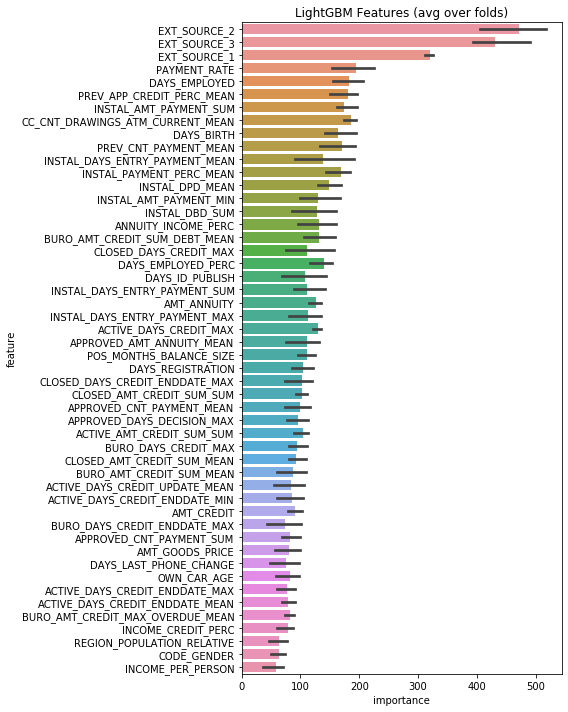

In [44]:
t0 = time.time()
fit_model, pred_train, pred_new, FI, df_with_pred = kfold_lightgbm2(df_test_under, debug=False)
print("{} - done in {:.0f}s".format('Modèle entrainé :', time.time() - t0))

In [45]:
pickle.dump(fit_model, open('LGBM_predict_default_credit.pkl', 'wb'))

#### 5.4 - [Interprétabilité du modèle](#54)<a class="anchor" id="54"></a>

In [81]:
df_expl

index  SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  \
0         6089      107120     0.0                   0            0   
1       112946      231003     0.0                   1            0   
2       175619      303510     0.0                   0            0   
3       124603      244505     0.0                   0            1   
4       225396      361073     0.0                   1            0   
...        ...         ...     ...                 ...          ...   
153748    7624      108886     1.0                   0            1   
153749  290691      436761     1.0                   1            0   
153750  217032      351472     1.0                   0            0   
153751  220234      355134     1.0                   0            0   
153752  152029      276214     1.0                   0            0   

        FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0                  1                0             0          135000.0   
1                  0                1             0          360000.0   
2                  0                1             1          157500.0   
3                  1                0             0          202500.0   
4                  0                1             0          112500.0   
...              ...              ...           ...               ...   
153748             0                0             0          121500.0   
153749             0                1             2          112500.0   
153750             0                1             1          103500.0   
153751             0                1             0          184500.0   
153752             0                0             1          157500.0   

        AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0         505066.5      27036.0         468000.0                    0.010147   
1         495000.0      24750.0         495000.0                    0.011657   
2         675000.0      50598.0         675000.0                    0.005002   
3        1350000.0      39474.0        1350000.0                    0.035792   
4         315000.0      15750.0         315000.0                    0.020246   
...            ...          ...              ...                         ...   
153748    225000.0      17775.0         225000.0                    0.006305   
153749    202500.0      10125.0         202500.0                    0.031329   
153750    545040.0      26509.5         450000.0                    0.019689   
153751   1264428.0      37098.0         990000.0                    0.018634   
153752    414792.0      28188.0         315000.0                    0.003818   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0           -17335        -4971.0            -8737.0             -874   
1           -22540            NaN            -6983.0            -1925   
2           -11004        -4222.0            -5350.0             -764   
3           -16662        -2503.0            -2511.0             -197   
4           -19290        -1275.0            -2170.0            -1131   
...            ...            ...                ...              ...   
153748      -10177         -112.0            -4270.0            -2597   
153749      -12771        -1299.0             -392.0             -410   
153750      -14511        -7130.0           -11164.0             -658   
153751      -13337        -2593.0            -7412.0            -4227   
153752      -10101         -492.0            -4060.0              -95   

        OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0              17.0           1               1                0   
1               NaN           1               0                0   
2               NaN           1               1                0   
3               3.0           1               1                0   
4               NaN           1               1                1   
...             ...         ...  

In [73]:
# Building dataframe for LIME interpretability
df_expl = pd.concat([df_class_0_under, df_class_1_under], axis=0)
df_expl.reset_index(drop=True, inplace=True)
# Looking for default 
df_expl[df_expl['TARGET'] == 1]

index  SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  \
141341  279941      424346     1.0                   0            0   
141342  181141      309926     1.0                   0            0   
141343   24939      129006     1.0                   0            0   
141344   69696      180842     1.0                   0            0   
141345   31040      136030     1.0                   0            0   
...        ...         ...     ...                 ...          ...   
153748    7624      108886     1.0                   0            1   
153749  290691      436761     1.0                   1            0   
153750  217032      351472     1.0                   0            0   
153751  220234      355134     1.0                   0            0   
153752  152029      276214     1.0                   0            0   

        FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
141341             0                1             2           76500.0   
141342             0                0             0          270000.0   
141343             0                1             2          157500.0   
141344             1                0             0          180000.0   
141345             0                1             0          144000.0   
...              ...              ...           ...               ...   
153748             0                0             0          121500.0   
153749             0                1             2          112500.0   
153750             0                1             1          103500.0   
153751             0                1             0          184500.0   
153752             0                0             1          157500.0   

        AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
141341    509400.0      40374.0         450000.0                    0.019689   
141342    251280.0      13761.0         180000.0                    0.003818   
141343   1288350.0      37800.0        1125000.0                    0.020713   
141344   1530000.0      42075.0        1530000.0                    0.031329   
141345    544500.0      26325.0         544500.0                    0.028663   
...            ...          ...              ...                         ...   
153748    225000.0      17775.0         225000.0                    0.006305   
153749    202500.0      10125.0         202500.0                    0.031329   
153750    545040.0      26509.5         450000.0                    0.019689   
153751   1264428.0      37098.0         990000.0                    0.018634   
153752    414792.0      28188.0         315000.0                    0.003818   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
141341      -11324         -216.0             -569.0            -1041   
141342      -13449        -1483.0            -4046.0            -4046   
141343      -15873         -123.0            -1176.0            -1441   
141344       -9601         -578.0            -9422.0             -555   
141345      -13467        -5496.0             -395.0            -3157   
...            ...            ...                ...              ...   
153748      -10177         -112.0            -4270.0            -2597   
153749      -12771        -1299.0             -392.0             -410   
153750      -14511        -7130.0           -11164.0             -658   
153751      -13337        -2593.0            -7412.0            -4227   
153752      -10101         -492.0            -4060.0              -95   

        OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
141341          NaN           1               1                0   
141342          NaN           1               1                0   
141343          NaN           1               1                0   
141344          2.0           1               1                1   
141345          NaN           1               1                0   
...             ...         ...  

In [74]:
# Transforming into array to use LIME
train = df_expl.drop(['TARGET', 'index'], axis=1)
train.set_index('SK_ID_CURR',inplace=True)
train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.fillna(train.mean(),inplace=True)
train_array=train.to_numpy()
train.head(5)

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
SK_ID_CURR                                                                   
107120                       0            0             1                0   
231003                       1            0             0                1   
303510                       0            0             0                1   
244505                       0            1             1                0   
361073                       1            0             0                1   

            CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
107120                 0          135000.0    505066.5      27036.0   
231003                 0          360000.0    495000.0      24750.0   
303510                 1          157500.0    675000.0      50598.0   
244505                 0          202500.0   1350000.0      39474.0   
361073                 0          112500.0    315000.0      15750.0   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
107120             468000.0                    0.010147      -17335   
231003             495000.0                    0.011657      -22540   
303510             675000.0                    0.005002      -11004   
244505            1350000.0                    0.035792      -16662   
361073             315000.0                    0.020246      -19290   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                                                                   
107120       -4971.000000            -8737.0             -874    17.000000   
231003       -2385.033488            -6983.0            -1925    11.972277   
303510       -4222.000000            -5350.0             -764    11.972277   
244505       -2503.000000            -2511.0             -197     3.000000   
361073       -1275.000000            -2170.0            -1131    11.972277   

            FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
SK_ID_CURR                                                                  
107120               1               1                0                 1   
231003               1               0                0                 1   
303510               1               1                0                 1   
244505               1               1                0                 1   
361073               1               1                1                 1   

            FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                                  
107120               0           0              2.0                     2   
231003               0           0              1.0                     1   
303510               1           0              3.0                     3   
244505               1           0              2.0                     2   
361073               1           0              1.0                     3   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
107120                                2                       12   
231003                                1                       10   
303510                                3                       16   
244505                                2                        9   
361073                                3                        9   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
107120                               0                           0   
231003                               0                           0   
303510                               0                           0   
244505         

In [75]:
# Creating fetature list and categorical feature list
feature_names = train.columns.values.tolist()
categorical_features=[]
for i, cat in enumerate(feature_names):
    if train[cat].nunique() == 2:
        categorical_features.append(i)
#Creating dict with possible value for cat features.
categorical_names = {}
for feature in categorical_features:
    categorical_names[feature] = np.array([0,1])
    
class_names = ['0 : Crédit remboursé','1 : défaut crédit']

In [76]:
# Initialize Lime explainer
explainer = lime.lime_tabular.LimeTabularExplainer(train_array,
                                                  feature_names = feature_names,
                                                  class_names=class_names,
                                                  categorical_features=categorical_features, 
                                                  categorical_names=categorical_names,
                                                  discretize_continuous=False
                                                  )

In [52]:
predict_fn = lambda x: fit_model.predict_proba(x).astype(float)
np.random.seed(1)
i = 1
exp = explainer.explain_instance(train_array[i], predict_fn, num_features=10)
exp.show_in_notebook(show_all=False)

In [85]:
i = 141345
exp = explainer.explain_instance(train_array[i], predict_fn, num_features=10)
exp.show_in_notebook(show_all=False)

#### 5.5 - [Donnée exportée](#55)<a class="anchor" id="55"></a>

In [54]:
cols = FI[["feature", "importance"]].groupby("feature").mean().\
                                            sort_values(by="importance",
                                            ascending=False)[:15].index

Most_important_features = cols.tolist()
Most_important_features

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'PAYMENT_RATE',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'DAYS_EMPLOYED',
 'PREV_APP_CREDIT_PERC_MEAN',
 'INSTAL_AMT_PAYMENT_SUM',
 'PREV_CNT_PAYMENT_MEAN',
 'INSTAL_PAYMENT_PERC_MEAN',
 'DAYS_BIRTH',
 'INSTAL_DPD_MEAN',
 'DAYS_EMPLOYED_PERC',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'ANNUITY_INCOME_PERC']

In [56]:
# On concatène nos df test et train pour avoir les données au même endroit
df_csv = pd.concat([df_max_profit, df_with_pred], axis=0, join='outer')
df_csv.drop_duplicates(subset = ['SK_ID_CURR'],keep = 'last', inplace = True)
data_test = df_max_profit_test.drop(['TARGET','index'],axis=1)
data_test_api = df_max_profit_test.drop(['TARGET','index'],axis=1)

In [57]:
#Selecting and renaming of important features for dashboard:
Desc_feature = ["SK_ID_CURR", 'TARGET','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY',
               'PREV_APP_CREDIT_PERC_MEAN','INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_SUM',
                'PREV_CNT_PAYMENT_MEAN', 'DAYS_EMPLOYED', 'PAYMENT_RATE','DAYS_BIRTH', ]

df_csv_export = df_csv[[c for c in df_csv.columns if c in Desc_feature]]
rename_column ={'AMT_INCOME_TOTAL':'Revenu', 'AMT_CREDIT':'Capital demande', 'AMT_ANNUITY':'Annuite',
               'AMT_GOODS_PRICE':'Valeur Imobiliere', 'DAYS_BIRTH':'Age','DAYS_EMPLOYED':'Anciennete',
               'PREV_APP_CREDIT_PERC_MEAN':'Mean(Capital demande/Capital pret)',
                'INSTAL_AMT_PAYMENT_MIN':'Min paye/traite', 'INSTAL_AMT_PAYMENT_SUM':'Somme pret payee',
                'PREV_CNT_PAYMENT_MEAN':'Duree moy prec credit', 'PAYMENT_RATE':'Annuite/Capital pret'
               }
df_csv_export.rename(columns=rename_column, inplace=True)
data_test.rename(columns=rename_column, inplace=True)

C:\anaconda\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [58]:
df_csv_export['Age'] /=-365
df_csv_export['Anciennete'] /=-365
data_test['Age'] /=-365
data_test['Anciennete'] /=-365

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
df_csv_export[['TARGET', 'Age', 'Anciennete', 'Annuite/Capital pret',
              'Mean(Capital demande/Capital pret)', 'Somme pret payee', 'Duree moy prec credit']] = df_csv_export[['TARGET', 'Age',
              'Anciennete', 'Annuite/Capital pret',
              'Mean(Capital demande/Capital pret)', 'Somme pret payee', 'Duree moy prec credit']].round(decimals=3)

C:\anaconda\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [60]:
# Features qui doivent être remplie pour fair tourner l'algorithme.
Features = data_test_api.columns.tolist()
Features

['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCU

On exporte les données des features importantes pour le modèle ainsi que le df sur les clients tests pour alimenter l'algorithme:


In [62]:
# Dataframe to compare with existing customer used in training:
df_csv_export.to_csv(path_out+"df_csv_export.csv",index=False, sep=',', encoding='utf-8')
#Dataframe pour appeler l'API
data_test.to_csv(path_out+"data_test.csv",index=False, sep=',', encoding='utf-8')

#### 5.6 - [Plus proche voisin (kNN)](#56)<a class="anchor" id="56"></a>

In [87]:
df_knn = df_csv_export.drop(['TARGET'], axis=1)
df_knn.set_index('SK_ID_CURR', inplace=True)
# remove infinite value
df_knn.replace([np.inf, -np.inf], np.nan, inplace=True)
#Imputation par la moyenne
df_knn.fillna(df_knn.mean(), inplace=True)
df_knn

Revenu  Capital demande  Annuite  Valeur Imobiliere     Age  \
SK_ID_CURR                                                                  
100002      202500.0         406597.5  24700.5           351000.0  25.921   
100003      270000.0        1293502.5  35698.5          1129500.0  45.932   
100004       67500.0         135000.0   6750.0           135000.0  52.181   
100006      135000.0         312682.5  29686.5           297000.0  52.068   
100007      121500.0         513000.0  21865.5           513000.0  54.608   
...              ...              ...      ...                ...     ...   
456221      121500.0         412560.0  17473.5           270000.0  54.712   
456222      157500.0         622413.0  31909.5           495000.0  30.647   
456223      202500.0         315000.0  33205.5           315000.0  43.622   
456224      225000.0         450000.0  25128.0           450000.0  38.268   
456250      135000.0         312768.0  24709.5           270000.0  38.252   

            Anciennete  Annuite/Capital pret  \
SK_ID_CURR                                     
100002           1.745                 0.061   
100003           3.255                 0.028   
100004           0.616                 0.050   
100006           8.326                 0.095   
100007           8.323                 0.043   
...                ...                   ...   
456221          14.162                 0.042   
456222           3.148                 0.051   
456223           8.321                 0.105   
456224           7.482                 0.056   
456250           1.734                 0.079   

            Mean(Capital demande/Capital pret)  Duree moy prec credit  \
SK_ID_CURR                                                              
100002                                   1.000                 24.000   
100003                                   0.949                 10.000   
100004                                   1.208                  4.000   
100006                                   1.011                 23.000   
100007                                   0.970                 20.667   
...                                        ...                    ...   
456221                                   0.883                 24.000   
456222                                   0.919                 17.500   
456223                                   1.056                 11.000   
456224                                   0.913                 14.500   
456250                                   0.948                 15.600   

            Min paye/traite  Somme pret payee  
SK_ID_CURR                                     
100002             9251.775        219625.695  
100003             6662.970       1618864.650  
100004             5357.250         21288.465  
100006             2482.920       1007153.415  
100007                0.180        806127.975  
...                     ...               ...  
456221            14222.430        273109.365  
456222                2.700        567315.675  
456223            12640.950        185271.930  
456224             5519.925        500807.790  
456250                1.080        652249.170  

[356251 rows x 11 columns]

In [88]:
# Centrage- Réduction
feat = df_knn.columns.tolist()
scaler = preprocessing.StandardScaler()
df_knn[feat] = scaler.fit_transform(df_knn[feat])
df_knn

Revenu  Capital demande   Annuite  Valeur Imobiliere       Age  \
SK_ID_CURR                                                                     
100002      0.144890        -0.454493 -0.184980          -0.483767 -1.509618   
100003      0.446893         1.770419  0.561553           1.643734  0.166079   
100004     -0.459116        -1.135829 -1.403442          -1.074056  0.689363   
100006     -0.157113        -0.690090  0.153465          -0.631339  0.679900   
100007     -0.217513        -0.187569 -0.377417          -0.041050  0.892597   
...              ...              ...       ...                ...       ...   
456221     -0.217513        -0.439535 -0.675542          -0.705126  0.901305   
456222     -0.056445         0.086907  0.304360          -0.090241 -1.113869   
456223      0.144890        -0.684276  0.392331          -0.582149 -0.027358   
456224      0.245558        -0.345612 -0.155962          -0.213218 -0.475695   
456250     -0.157113        -0.689876 -0.184369          -0.705126 -0.477035   

            Anciennete  Annuite/Capital pret  \
SK_ID_CURR                                     
100002       -0.833200              0.240825   
100003       -0.572243             -1.178864   
100004       -1.028312             -0.232404   
100006        0.304120              1.703536   
100007        0.303602             -0.533551   
...                ...                   ...   
456221        1.312690             -0.576572   
456222       -0.590735             -0.189383   
456223        0.303256              2.133745   
456224        0.158261              0.025721   
456250       -0.835101              1.015202   

            Mean(Capital demande/Capital pret)  Duree moy prec credit  \
SK_ID_CURR                                                              
100002                                0.183470               1.155122   
100003                               -0.123625              -0.553160   
100004                                1.435935              -1.285281   
100006                                0.249706               1.033102   
100007                                0.002826               0.748429   
...                                        ...                    ...   
456221                               -0.521042               1.155122   
456222                               -0.304269               0.361991   
456223                                0.520672              -0.431140   
456224                               -0.340398              -0.004070   
456250                               -0.129646               0.130152   

            Min paye/traite  Somme pret payee  
SK_ID_CURR                                     
100002             0.280390         -0.518086  
100003             0.097504          1.021483  
100004             0.005261         -0.736314  
100006            -0.197796          0.348423  
100007            -0.373189          0.127237  
...                     ...               ...  
456221             0.631541         -0.459238  
456222            -0.373011         -0.135526  
456223             0.519818         -0.555885  
456224             0.016753         -0.208704  
456250            -0.373125         -0.042075  

[356251 rows x 11 columns]

In [89]:
nbrs = NearestNeighbors(n_neighbors=16, algorithm='ball_tree').fit(df_knn)
distances, indices = nbrs.kneighbors(df_knn)

In [90]:
#Replacing indices by SK_ID_CURR and creating df for export
for j in range (len(indices)):
    for i in range(len(indices[0])):
        tmp = indices[j][i]
        indices[j][i]=list_knn[tmp]

columns=['SK_ID_CURR', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10',
        'N11', 'N12', 'N13', 'N14', 'N15']
df_knn_export = pd.DataFrame(indices, columns=columns)
df_knn_export

SK_ID_CURR      N1      N2      N3      N4      N5      N6      N7  \
0           100002  408240  106823  415879  288249  104246  143734  357457   
1           100003  334649  349155  327323  331997  370420  210244  278713   
2           100004  378877  364172  319427  204810  452940  216104  420654   
3           100006  449230  188703  444758  369872  222015  437853  370662   
4           100007  345990  226488  329944  195737  195752  159778  336701   
...            ...     ...     ...     ...     ...     ...     ...     ...   
356246      456221  320568  148122  136172  378642  169152  153349  186378   
356247      456222  439893  275530  421684  359549  414255  117479  216556   
356248      456223  259478  200768  415712  320090  455849  145853  324786   
356249      456224  296092  349130  175083  291873  198558  413562  307513   
356250      456250  414043  301169  420085  387594  289565  174538  385544   

            N8      N9     N10     N11     N12     N13     N14     N15  
0       428996  319542  442742  355990  372563  389027  221210  118136  
1       398568  450463  308693  327688  381820  170100  196557  262367  
2       158874  224280  357925  206788  333846  142363  172185  153192  
3       318280  121232  378506  119343  181761  296264  216128  292741  
4       208719  389800  355269  184595  173414  430763  384357  392978  
...        ...     ...     ...     ...     ...     ...     ...     ...  
356246  351103  376360  243211  258315  207552  351269  432713  424953  
356247  198127  156568  108089  161831  125140  300779  336011  276896  
356248  140737  335691  374076  319736  156248  145490  240432  328130  
356249  230148  234662  413429  405240  380563  126948  344851  315621  
356250  166737  107479  329382  231632  197969  339067  450458  409622  

[356251 rows x 16 columns]

On exporte ces données pour la Dashboard :

In [70]:
df_knn_export.to_csv(path_out+"df_knn_export.csv",index=False, sep=',', encoding='utf-8')

### 6 - [Appel API](#6)<a class="anchor" id="6"></a>

In [71]:
import json
test_param = data_test_api[data_test_api['SK_ID_CURR'] == 100001]
test_param.drop(['SK_ID_CURR'], axis=1, inplace=True)
test_param_d = test_param.to_dict('records')[0]
test_param_d

C:\anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


{'NAME_CONTRACT_TYPE': 0,
 'CODE_GENDER': 0,
 'FLAG_OWN_CAR': 0,
 'FLAG_OWN_REALTY': 1,
 'CNT_CHILDREN': 0,
 'AMT_INCOME_TOTAL': 135000.0,
 'AMT_CREDIT': 568800.0,
 'AMT_ANNUITY': 20560.5,
 'AMT_GOODS_PRICE': 450000.0,
 'REGION_POPULATION_RELATIVE': 0.01885,
 'DAYS_BIRTH': -19241,
 'DAYS_EMPLOYED': -2329.0,
 'DAYS_REGISTRATION': -5170.0,
 'DAYS_ID_PUBLISH': -812,
 'OWN_CAR_AGE': nan,
 'FLAG_MOBIL': 1,
 'FLAG_EMP_PHONE': 1,
 'FLAG_WORK_PHONE': 0,
 'FLAG_CONT_MOBILE': 1,
 'FLAG_PHONE': 0,
 'FLAG_EMAIL': 1,
 'CNT_FAM_MEMBERS': 2.0,
 'REGION_RATING_CLIENT': 2,
 'REGION_RATING_CLIENT_W_CITY': 2,
 'HOUR_APPR_PROCESS_START': 18,
 'REG_REGION_NOT_LIVE_REGION': 0,
 'REG_REGION_NOT_WORK_REGION': 0,
 'LIVE_REGION_NOT_WORK_REGION': 0,
 'REG_CITY_NOT_LIVE_CITY': 0,
 'REG_CITY_NOT_WORK_CITY': 0,
 'LIVE_CITY_NOT_WORK_CITY': 0,
 'EXT_SOURCE_1': 0.7526144906031748,
 'EXT_SOURCE_2': 0.7896543511176771,
 'EXT_SOURCE_3': 0.1595195404777181,
 'DAYS_LAST_PHONE_CHANGE': -1740.0,
 'FLAG_DOCUMENT_2': 0,
 'FLAG

In [72]:
import requests
url='https://apiflaskoc.herokuapp.com/predict_api'
response = requests.post(url, json=test_param_d)
response.json()

0.04031664295314622